In [1]:
# A) Cabecera y rutas
import os, json, math, textwrap, glob
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Rutas base (ajusta si lo tienes en otra ubicación)
DRIVE = Path("/content/drive/MyDrive/CognitivaAI")

P11 = DRIVE / "p11_alt_backbones"
P13 = DRIVE / "p13_oasis2_images"
P14 = DRIVE / "p14_oasis2_images"

OUT = DRIVE / "p15_consolidacion"
OUT.mkdir(parents=True, exist_ok=True)

print("Rutas:")
print(" P11:", P11)
print(" P13:", P13)
print(" P14:", P14)
print(" OUT:", OUT)

Mounted at /content/drive
Rutas:
 P11: /content/drive/MyDrive/CognitivaAI/p11_alt_backbones
 P13: /content/drive/MyDrive/CognitivaAI/p13_oasis2_images
 P14: /content/drive/MyDrive/CognitivaAI/p14_oasis2_images
 OUT: /content/drive/MyDrive/CognitivaAI/p15_consolidacion


In [2]:
# B) Utilidades

def read_csv_safe(path, **kwargs):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] No existe: {p}")
        return None
    try:
        return pd.read_csv(p, **kwargs)
    except Exception as e:
        print(f"[WARN] Error leyendo {p.name}: {e}")
        return None

def read_json_safe(path):
    p = Path(path)
    if not p.exists():
        print(f"[WARN] No existe: {p}")
        return None
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Error leyendo JSON {p.name}: {e}")
        return None

def std_cols_png_preds(df):
    """
    Estandariza columnas esperadas en predicciones por-slice:
      - patient_id, png_path, y_true, y_score
    """
    if df is None or len(df)==0:
        return df

    cols = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for c in cands:
            if c in cols: return cols[c]
        return None

    c_pid = pick("patient_id")
    c_png = pick("png_path")
    c_true = pick("y_true","target")
    c_score= pick("y_score","sigmoid(logit)","sigmoid(logits)","pred","score","prob","proba")

    need = [c_pid, c_png, c_true, c_score]
    if any(c is None for c in need):
        print("[WARN] Faltan columnas en preds por-slice:", df.columns.tolist())
        return None

    out = df.rename(columns={
        c_pid:"patient_id", c_png:"png_path", c_true:"y_true", c_score:"y_score"
    }).copy()

    # Tipos
    out["y_true"] = out["y_true"].astype(float)
    out["y_score"]= out["y_score"].astype(float)
    return out

def pool_patient(df):
    """
    Aplica pooling a nivel paciente desde preds por slice.
    Devuelve: patient_id, y_true, mean, trimmed20, top7, pmean_2
    """
    if df is None or len(df)==0: return None
    def trimmed_mean(s, frac=0.1):
        k = int(len(s)*frac)
        if k==0: return s.mean()
        s2 = np.sort(s)[k:len(s)-k]
        if len(s2)==0: return s.mean()
        return s2.mean()

    def topk_mean(s, k=7):
        k = min(k, len(s))
        return np.sort(s)[-k:].mean()

    def pmean(s, p=2):
        s = np.clip(s,0,1)
        return (np.mean(s**p))**(1/p)

    g = df.groupby("patient_id", as_index=False)
    agg = g.agg(y_true=("y_true","mean"),
                mean=("y_score","mean"),
                trimmed20=("y_score", lambda s: trimmed_mean(np.array(s), 0.1)),
                top7=("y_score", lambda s: topk_mean(np.array(s), 7)),
                pmean_2=("y_score", lambda s: pmean(np.array(s),2)))
    agg["y_true"] = agg["y_true"].round().astype(int)
    return agg

def eval_binary(y_true, y_score, thr=None):
    """
    Métricas añadiendo AUC/PR-AUC.
    Si thr es None, usa 0.5.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score= np.asarray(y_score).astype(float)
    if thr is None: thr = 0.5

    # Robustos a casos con una sola clase:
    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = np.nan
    try:
        prauc = average_precision_score(y_true, y_score)
    except Exception:
        prauc = np.nan

    y_pred = (y_score >= thr).astype(int)
    acc = (y_pred == y_true).mean() if len(y_true)>0 else np.nan
    P = ( (y_pred[y_true==1]==1).sum() / max((y_pred==1).sum(),1) ) if (y_pred==1).sum()>0 else 0.0
    R = ( (y_pred[y_true==1]==1).sum() / max((y_true==1).sum(),1) ) if (y_true==1).sum()>0 else 0.0
    return dict(AUC=float(auc), PRAUC=float(prauc), Acc=float(acc), P=float(P), R=float(R), thr=float(thr), n=int(len(y_true)))

def quick_bar(ax, labels, values, title, ylabel=None):
    ax.bar(range(len(values)), values)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    ax.grid(axis="y", alpha=.3)


In [3]:
# C) Cargar resultados existentes

# p11: catálogo y features ya unificadas
p11_catalog = read_json_safe(P11/"p11_backbone_catalog.json")
p11_val_feats = read_csv_safe(P11/"val_patient_features_backbones.csv")
p11_tst_feats = read_csv_safe(P11/"test_patient_features_backbones.csv")
p11_cmp       = read_csv_safe(P11/"comparison_backbones_eval.csv")  # resumen comparativo si existe

# p13 (OAS2): resúmenes y predicciones
p13_summary = read_json_safe(P13/"p13_patient_eval_summary.json")
p13_val_png = read_csv_safe(P13/"val_png_preds_oas2_effb3.csv")
p13_tst_png = read_csv_safe(P13/"test_png_preds_oas2_effb3.csv")
p13_val_pt  = read_csv_safe(P13/"val_patient_preds_oas2_effb3.csv")
p13_tst_pt  = read_csv_safe(P13/"test_patient_preds_oas2_effb3.csv")

# p14 (OAS2 con SSD + mejoras): resúmenes y predicciones
p14_summary = read_json_safe(P14/"p14_patient_eval_summary.json")
p14_val_png = read_csv_safe(P14/"val_png_preds_oas2_effb3_p14.csv")
p14_tst_png = read_csv_safe(P14/"test_png_preds_oas2_effb3_p14.csv")
p14_val_pt  = read_csv_safe(P14/"val_patient_preds_oas2_effb3_p14.csv")
p14_tst_pt  = read_csv_safe(P14/"test_patient_preds_oas2_effb3_p14.csv")

print("p11_val_feats:", None if p11_val_feats is None else p11_val_feats.shape)
print("p11_tst_feats:", None if p11_tst_feats is None else p11_tst_feats.shape)
print("p13_val_pt:", None if p13_val_pt is None else p13_val_pt.shape, "| p14_val_pt:", None if p14_val_pt is None else p14_val_pt.shape)


p11_val_feats: (69, 58)
p11_tst_feats: (70, 58)
p13_val_pt: (22, 6) | p14_val_pt: (22, 3)


In [4]:
# D) Si solo hay por-slice, construimos por-paciente (mean/trimmed/top7/pmean_2)

def ensure_patient_level(val_png_df, tst_png_df, tag):
    out = {}
    for split, df in [("VAL", val_png_df), ("TEST", tst_png_df)]:
        if df is None or len(df)==0:
            out[split] = None
            continue
        S = std_cols_png_preds(df)
        P = pool_patient(S) if S is not None else None
        out[split] = P
        if P is not None:
            P.to_csv(OUT/f"{tag.lower()}_{split.lower()}_patient_pooled.csv", index=False)
            print(f"Guardado pooling {tag} {split}: {P.shape} → {OUT/f'{tag.lower()}_{split.lower()}_patient_pooled.csv'}")
    return out

# p13
p13_pooled = ensure_patient_level(p13_val_png, p13_tst_png, tag="P13_OAS2_EffB3")
# p14
p14_pooled = ensure_patient_level(p14_val_png, p14_tst_png, tag="P14_OAS2_EffB3")

# fallback: si ya teníamos patient_preds, priorizamos esos
if p13_val_pt is not None: p13_pooled["VAL"] = p13_val_pt
if p13_tst_pt is not None: p13_pooled["TEST"] = p13_tst_pt
if p14_val_pt is not None: p14_pooled["VAL"] = p14_val_pt
if p14_tst_pt is not None: p14_pooled["TEST"] = p14_tst_pt


Guardado pooling P13_OAS2_EffB3 VAL: (22, 6) → /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p13_oas2_effb3_val_patient_pooled.csv
Guardado pooling P13_OAS2_EffB3 TEST: (23, 6) → /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p13_oas2_effb3_test_patient_pooled.csv
Guardado pooling P14_OAS2_EffB3 VAL: (22, 6) → /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p14_oas2_effb3_val_patient_pooled.csv
Guardado pooling P14_OAS2_EffB3 TEST: (23, 6) → /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p14_oas2_effb3_test_patient_pooled.csv


In [5]:
# E) Tabla maestra. Incluir:
#  - OAS1 (p11 features agregadas ya contienen muchas señales; tomamos una "AVG" y SwinTiny_top7 como referencia)
#  - OAS2 p13 y p14 (mean/trimmed20/top7/pmean_2)

def pick_columns(df, prefix):
    """
    Elige columnas principales de p11 para comparación:
    - SwinTiny_top7, SwinTiny_mean
    - convnext..._top7
    - png_preds_d121_trimmed20
    Y un 'avg' si existe (o construimos uno).
    """
    if df is None: return None
    df = df.copy()
    # calc AVG si existen varias columnas _mean populares
    score_cols = [c for c in df.columns if any(k in c for k in ["_mean","_top7","_trimmed20","_p2"]) and c not in ["y_true"]]
    if len(score_cols)>=2 and "avg_all" not in df.columns:
        df["avg_all"] = df[score_cols].mean(axis=1)

    keep = ["patient_id","y_true"]
    for k in ["SwinTiny_top7","SwinTiny_mean",
              "convnext_tiny.in12k_ft_in1k_slices_top7",
              "png_preds_d121_trimmed20",
              "avg_all"]:
        if k in df.columns: keep.append(k)
    out = df[keep].copy()
    # Prefijo para diferenciar cohortes
    for c in out.columns:
        if c not in ["patient_id","y_true"]:
            out.rename(columns={c: f"{prefix}_{c}"}, inplace=True)
    # Volver a meter y_true sin prefijo para facilitar merges posteriores
    out.rename(columns={f"{prefix}_y_true":"y_true"}, inplace=True)
    return out

OAS1_VAL = pick_columns(p11_val_feats, "OAS1")
OAS1_TST = pick_columns(p11_tst_feats, "OAS1")

def std_pt(df, prefix):
    # asegurar columnas: patient_id, y_true, mean, trimmed20, top7, pmean_2
    if df is None: return None
    have = df.columns
    need = ["patient_id","y_true","mean","trimmed20","top7","pmean_2"]
    missing = [c for c in need if c not in have]
    if missing:
        print(f"[WARN] {prefix} faltan columnas {missing} → intento de auto-detección")
        # no forzamos; devolvemos tal cual
    out = df.copy()
    # Prefijar nombres de scores
    rep = {}
    for c in out.columns:
        if c in ["patient_id","y_true"]: continue
        rep[c] = f"{prefix}_{c}"
    out = out.rename(columns=rep)
    return out

OAS2_P13_VAL = std_pt(p13_pooled["VAL"], "OAS2_p13")
OAS2_P13_TST = std_pt(p13_pooled["TEST"],"OAS2_p13")
OAS2_P14_VAL = std_pt(p14_pooled["VAL"], "OAS2_p14")
OAS2_P14_TST = std_pt(p14_pooled["TEST"],"OAS2_p14")

def outer_union(val_a, val_b):
    if val_a is None: return val_b
    if val_b is None: return val_a
    return pd.merge(val_a, val_b, on=["patient_id","y_true"], how="outer")

VAL_MASTER = None
for part in [OAS1_VAL, OAS2_P13_VAL, OAS2_P14_VAL]:
    VAL_MASTER = outer_union(VAL_MASTER, part)

TEST_MASTER = None
for part in [OAS1_TST, OAS2_P13_TST, OAS2_P14_TST]:
    TEST_MASTER = outer_union(TEST_MASTER, part)

print("VAL_MASTER:", None if VAL_MASTER is None else VAL_MASTER.shape)
print("TEST_MASTER:", None if TEST_MASTER is None else TEST_MASTER.shape)

VAL_MASTER.to_csv(OUT/"val_master_scores.csv", index=False)
TEST_MASTER.to_csv(OUT/"test_master_scores.csv", index=False)


[WARN] OAS2_p14 faltan columnas ['mean', 'trimmed20', 'top7', 'pmean_2'] → intento de auto-detección
[WARN] OAS2_p14 faltan columnas ['mean', 'trimmed20', 'top7', 'pmean_2'] → intento de auto-detección
VAL_MASTER: (69, 12)
TEST_MASTER: (70, 12)


In [6]:
# F) Métricas comparativas por columna de score (por split)
def evaluate_table(df, split_name, out_csv):
    if df is None or len(df)==0:
        print(f"[WARN] No hay datos en {split_name}")
        return pd.DataFrame()

    cols_score = [c for c in df.columns if c not in ["patient_id","y_true"]]
    rows = []
    for c in cols_score:
        s = df[c]
        # ignorar columnas que tengan muchos NaN
        nan_ratio = float(pd.isna(s).mean())
        if nan_ratio > 0.5:
            continue
        s = s.fillna(s.median())  # imputación simple para poder evaluar
        met = eval_binary(df["y_true"], s, thr=0.5)
        rows.append(dict(split=split_name, feature=c, nan_ratio=nan_ratio, **met))

    res = pd.DataFrame(rows).sort_values(["AUC","PRAUC"], ascending=[False,False])
    res.to_csv(out_csv, index=False)
    return res

VAL_RES = evaluate_table(VAL_MASTER, "VAL", OUT/"val_feature_ranking.csv")
TEST_RES= evaluate_table(TEST_MASTER,"TEST", OUT/"test_feature_ranking.csv")

display(VAL_RES.head(10))
display(TEST_RES.head(10))


,split,feature,nan_ratio,AUC,PRAUC,Acc,P,R,thr,n
4,VAL,OAS1_avg_all,0.000000,0.781834,0.766229,0.710145,0.648649,0.774194,0.5,69
2,VAL,OAS1_convnext_tiny.in12k_ft_in1k_slices_top7,0.318841,0.557725,0.518331,0.550725,0.000000,0.000000,0.5,69
0,VAL,OAS1_SwinTiny_top7,0.318841,0.465195,0.441359,0.492754,0.468750,0.967742,0.5,69
3,VAL,OAS1_png_preds_d121_trimmed20,0.318841,0.438879,0.451930,0.536232,0.444444,0.129032,0.5,69
1,VAL,OAS1_SwinTiny_mean,0.318841,0.345501,0.372018,0.536232,0.000000,0.000000,0.5,69


,split,feature,nan_ratio,AUC,PRAUC,Acc,P,R,thr,n
4,TEST,OAS1_avg_all,0.000000,0.740954,0.715230,0.714286,0.676471,0.71875,0.5,70
0,TEST,OAS1_SwinTiny_top7,0.328571,0.599507,0.565692,0.542857,0.500000,0.96875,0.5,70
1,TEST,OAS1_SwinTiny_mean,0.328571,0.534539,0.510699,0.557143,1.000000,0.03125,0.5,70
2,TEST,OAS1_convnext_tiny.in12k_ft_in1k_slices_top7,0.328571,0.533306,0.488997,0.542857,0.000000,0.00000,0.5,70
3,TEST,OAS1_png_preds_d121_trimmed20,0.328571,0.362253,0.439918,0.471429,0.222222,0.06250,0.5,70


In [7]:
# G) Resumen por bloque (texto y tabla)
summary_rows = []

def add_block(name, split_df, primary_cols):
    if split_df is None or len(split_df)==0:
        return
    for col in primary_cols:
        if col not in split_df.columns:
            continue
        s = split_df[col].fillna(split_df[col].median())
        met = eval_binary(split_df["y_true"], s, thr=0.5)
        summary_rows.append(dict(Block=name, Feature=col, **met))

# OAS1 (ejemplos típicos):
add_block("OAS1", VAL_MASTER, ["OAS1_SwinTiny_top7","OAS1_SwinTiny_mean","OAS1_png_preds_d121_trimmed20","OAS1_avg_all"])
add_block("OAS1", TEST_MASTER,["OAS1_SwinTiny_top7","OAS1_SwinTiny_mean","OAS1_png_preds_d121_trimmed20","OAS1_avg_all"])

# OAS2 p13/p14 (mean/top7)
add_block("OAS2_p13", VAL_MASTER, ["OAS2_p13_mean","OAS2_p13_top7","OAS2_p13_pmean_2"])
add_block("OAS2_p13", TEST_MASTER,["OAS2_p13_mean","OAS2_p13_top7","OAS2_p13_pmean_2"])

add_block("OAS2_p14", VAL_MASTER, ["OAS2_p14_mean","OAS2_p14_top7","OAS2_p14_pmean_2"])
add_block("OAS2_p14", TEST_MASTER,["OAS2_p14_mean","OAS2_p14_top7","OAS2_p14_pmean_2"])

SUMMARY = pd.DataFrame(summary_rows)
SUMMARY.to_csv(OUT/"consolidated_block_summary.csv", index=False)
display(SUMMARY.sort_values(["Block","AUC"], ascending=[True,False]).head(20))


,Block,Feature,AUC,PRAUC,Acc,P,R,thr,n
3,OAS1,OAS1_avg_all,0.781834,0.766229,0.710145,0.648649,0.774194,0.5,69
7,OAS1,OAS1_avg_all,0.740954,0.715230,0.714286,0.676471,0.718750,0.5,70
4,OAS1,OAS1_SwinTiny_top7,0.599507,0.565692,0.542857,0.500000,0.968750,0.5,70
5,OAS1,OAS1_SwinTiny_mean,0.534539,0.510699,0.557143,1.000000,0.031250,0.5,70
0,OAS1,OAS1_SwinTiny_top7,0.465195,0.441359,0.492754,0.468750,0.967742,0.5,69
2,OAS1,OAS1_png_preds_d121_trimmed20,0.438879,0.451930,0.536232,0.444444,0.129032,0.5,69
6,OAS1,OAS1_png_preds_d121_trimmed20,0.362253,0.439918,0.471429,0.222222,0.062500,0.5,70
1,OAS1,OAS1_SwinTiny_mean,0.345501,0.372018,0.536232,0.000000,0.000000,0.5,69
9,OAS2_p13,OAS2_p13_top7,0.681664,0.641159,0.478261,0.462687,1.000000,0.5,69
10,OAS2_p13,OAS2_p13_pmean_2,0.681664,0.641159,0.521739,0.484375,1.000000,0.5,69


Guardado: /content/drive/MyDrive/CognitivaAI/p15_consolidacion/val_top10_auc.png
Guardado: /content/drive/MyDrive/CognitivaAI/p15_consolidacion/test_top10_auc.png


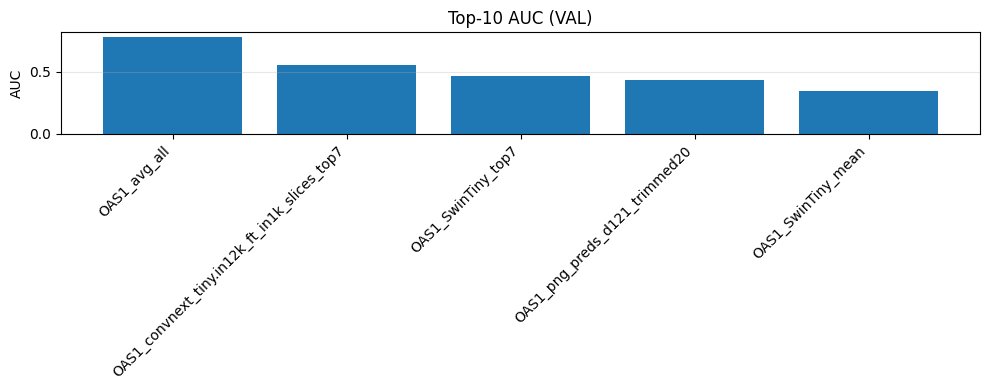

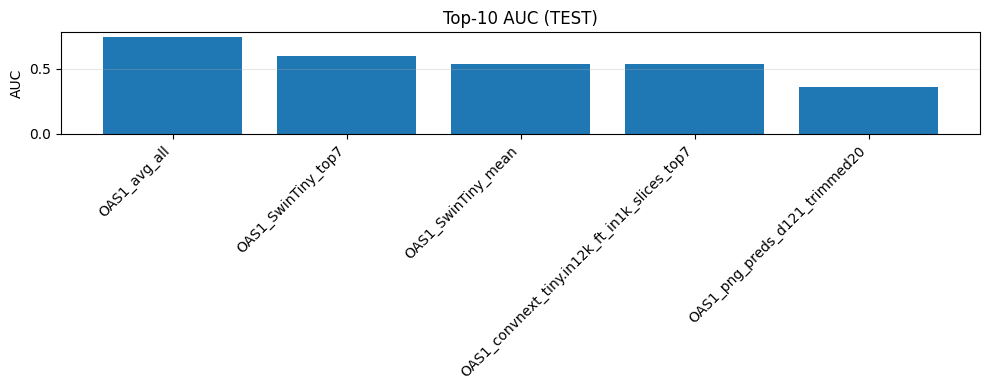

In [8]:
# H) Gráficas (bar) para TOP-K
def plot_topk(res_df, split, k=8, fname=""):
    if res_df is None or len(res_df)==0:
        return
    top = res_df.dropna(subset=["AUC"]).sort_values("AUC", ascending=False).head(k)
    labels = top["feature"].tolist()
    aucs   = top["AUC"].astype(float).tolist()
    praucs = top["PRAUC"].astype(float).tolist()

    fig, ax = plt.subplots(figsize=(10,4))
    quick_bar(ax, labels, aucs, f"Top-{k} AUC ({split})", ylabel="AUC")
    plt.tight_layout()
    if fname:
        out_path = OUT/fname
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
        print("Guardado:", out_path)

plot_topk(VAL_RES, "VAL", k=10, fname="val_top10_auc.png")
plot_topk(TEST_RES,"TEST",k=10, fname="test_top10_auc.png")


Guardados: /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p15_VAL_roc.png | /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p15_VAL_pr.png
Guardados: /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p15_TEST_roc.png | /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p15_TEST_pr.png


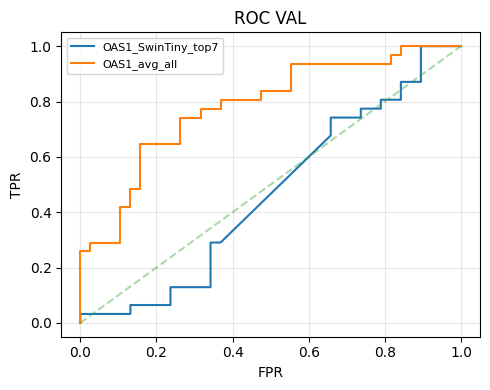

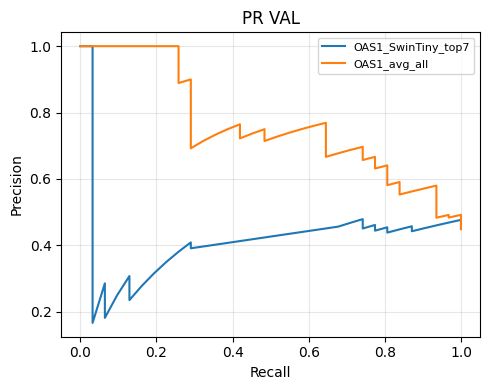

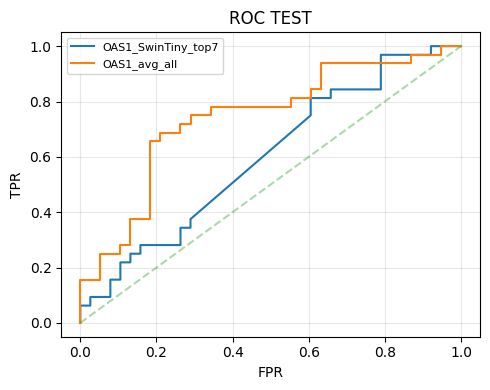

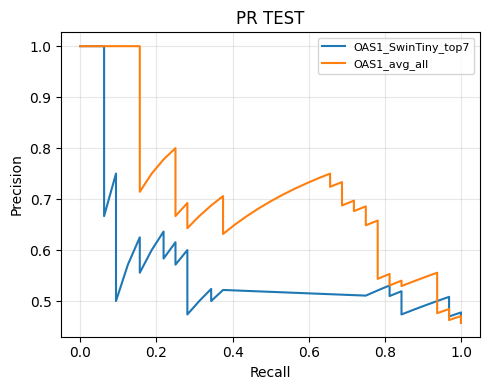

In [9]:
# I) Curvas ROC/PR para 3 señales candidatas por split

def plot_roc_pr(df, features, split, tag):
    if df is None or len(df)==0:
        return
    y = df["y_true"].astype(int).values
    fig1, ax1 = plt.subplots(figsize=(5,4))
    fig2, ax2 = plt.subplots(figsize=(5,4))

    for f in features:
        if f not in df.columns:
            continue
        s = df[f].astype(float).fillna(df[f].median()).values

        try:
            fpr, tpr, _ = roc_curve(y, s)
            ax1.plot(fpr, tpr, label=f)
        except Exception:
            pass

        try:
            prec, rec, _ = precision_recall_curve(y, s)
            ax2.plot(rec, prec, label=f)
        except Exception:
            pass

    ax1.plot([0,1],[0,1],"--",alpha=.4)
    ax1.set_title(f"ROC {split}")
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    ax1.legend(fontsize=8)
    ax1.grid(alpha=.3)

    ax2.set_title(f"PR {split}")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.legend(fontsize=8)
    ax2.grid(alpha=.3)

    fig1.tight_layout(); fig2.tight_layout()
    fig1.savefig(OUT/f"{tag}_{split}_roc.png", dpi=160, bbox_inches="tight")
    fig2.savefig(OUT/f"{tag}_{split}_pr.png",  dpi=160, bbox_inches="tight")
    print("Guardados:", OUT/f"{tag}_{split}_roc.png", "|", OUT/f"{tag}_{split}_pr.png")

# Elige 3 señales relevantes que existan en tus tablas:
cand_VAL  = [c for c in ["OAS1_SwinTiny_top7","OAS1_avg_all","OAS2_p14_top7"] if VAL_MASTER is not None and c in VAL_MASTER.columns]
cand_TEST = [c for c in ["OAS1_SwinTiny_top7","OAS1_avg_all","OAS2_p14_top7"] if TEST_MASTER is not None and c in TEST_MASTER.columns]

plot_roc_pr(VAL_MASTER,  cand_VAL,  "VAL",  tag="p15")
plot_roc_pr(TEST_MASTER, cand_TEST, "TEST", tag="p15")


In [10]:
# J) Exportar tablas ya “bonitas” (para README/Informe/Cuaderno)

def pretty_table(res_df, k=8):
    if res_df is None or len(res_df)==0:
        return pd.DataFrame()
    t = res_df.dropna(subset=["AUC"]).sort_values("AUC", ascending=False).head(k).copy()
    # Redondeos
    for c in ["AUC","PRAUC","Acc","P","R"]:
        if c in t.columns:
            t[c] = t[c].map(lambda x: np.nan if pd.isna(x) else round(float(x),3))
    return t

PT_VAL  = pretty_table(VAL_RES, 10)
PT_TEST = pretty_table(TEST_RES,10)

PT_VAL.to_csv(OUT/"val_top10_for_docs.csv", index=False)
PT_TEST.to_csv(OUT/"test_top10_for_docs.csv", index=False)

print("Tablas listas para documentación:")
print(" -", OUT/"val_top10_for_docs.csv")
print(" -", OUT/"test_top10_for_docs.csv")


Tablas listas para documentación:
 - /content/drive/MyDrive/CognitivaAI/p15_consolidacion/val_top10_for_docs.csv
 - /content/drive/MyDrive/CognitivaAI/p15_consolidacion/test_top10_for_docs.csv


In [11]:
# K) Contexto/metadata para anotar en la documentación (README/Informe/Cuaderno)
context = {
  "oasis2_preproc": {
    "slicing": "20 cortes axiales equiespaciados evitandos extremos (edge_crop≈0.08), CLAHE opcional, z-score por volumen dentro de máscara (FSL_SEG si disponible; fallback Otsu sobre proyección axial). PNG RGB 224x224.",
    "un_solo_escaneo_por_paciente": "Se seleccionó una sola sesión por paciente (estratificada con balances 0/1), evitando fugas entre splits.",
    "E/S_Colab": "Para entrenamiento se copió el dataset desde Drive a SSD local /content/datasets para reducir latencia.",
  },
  "p13": {
    "splits": "105/22/23 pacientes (Train/Val/Test) con 20 slices/paciente.",
    "resumen_json": str(P13 / "p13_patient_eval_summary.json")
  },
  "p14": {
    "mejoras": "Ruta SSD, class weights suaves, AMP, EffNet-B3 finetune con early-save por val_loss.",
    "resumen_json": str(P14 / "p14_patient_eval_summary.json")
  },
  "p11": {
    "catálogo": str(P11 / "p11_backbone_catalog.json"),
    "features_construidas": [
      str(P11/"val_patient_features_backbones.csv"),
      str(P11/"test_patient_features_backbones.csv")
    ]
  },
  "p15_outputs": [str(OUT/"val_master_scores.csv"),
                  str(OUT/"test_master_scores.csv"),
                  str(OUT/"val_feature_ranking.csv"),
                  str(OUT/"test_feature_ranking.csv"),
                  str(OUT/"consolidated_block_summary.csv")]
}

with open(OUT/"p15_context.json","w") as f:
    json.dump(context, f, indent=2)
print("Contexto guardado en:", OUT/"p15_context.json")


Contexto guardado en: /content/drive/MyDrive/CognitivaAI/p15_consolidacion/p15_context.json
